# How does Dominoes work? - A supervised learning approach to learn game dynamics and rewards from one-hot-encoded game states and actions.

## I. The Problem
### I.I. The Learning Problem
To learn the game dynamics, we have the model predict the next state (vector of length 30, one-hot encoded bist of information that describe the game state after an action) based on the previous state (length 30 one-hot-encoded vector) and an action (length 21 one-hot-encoded vector).  
### I.II. The Input Data
The input data consists of the current state (vector of length 30, one-hot encoded bist of information that describe the game state after an action) and an action (length 21 one-hot-encoded vector). We use it to predict either the next state (length 30 one-hot-encoded vector) or the probability that a given action in this situation leads to success.  
Since the data used for training is collected from multiple games using Monte Carlo Tree Search without accounting for history, it needs to be cleaned so that it is not the case that for the same combination of state and action, multiple probabilities can be learned.

In [1]:
import warnings  
import traceback
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


with warnings.catch_warnings():  
    warnings.filterwarnings("ignore",category=FutureWarning)
    import keras.backend as K
    from tensorflow.keras.callbacks import EarlyStopping
    import tensorflow as tf
    from tensorflow.keras.optimizers import SGD
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.layers import Dense, Dropout
    from tensorflow.keras.models import Sequential, Model, clone_model
    from tensorflow.keras.regularizers import l2

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from itertools import product

rnd_state = 1

Using TensorFlow backend.


In [2]:
#check if GPU is available for calculations
tf.config.experimental.list_physical_devices('GPU')

[]

In [3]:
"""
reads in training data from file and divides it into input state, next state and probability of winning
outputs a dictionary with training and testing data
"""

def divide_train_data(training_path, clean = False, test_size = 0.1):
    pandas_train = pd.read_csv(training_path,sep=';')
    if clean:
        pandas_train = clean_data(pandas_train)
    pandas_train = pandas_train.sample(frac=1, random_state=rnd_state).reset_index(drop=True)
    train, test = train_test_split(pandas_train,test_size = test_size, shuffle=False)
    print("With a test size of {}, we get {} training and {} testing samples.".format(test_size, train.shape[0], test.shape[0]))
    train_inputs = train.iloc[:,0:51]
    train_next_label = train.iloc[:,51:81]
    train_pred_label = train.iloc[:,-2:-1]
    test_inputs = test.iloc[:,0:51]
    test_next_label = test.iloc[:,51:81]
    test_pred_label = test.iloc[:,-2:-1]
    train_dict = {"input": train_inputs.to_numpy(), "next":train_next_label.to_numpy(), "pred": train_pred_label.to_numpy()}
    test_dict = {"input": test_inputs.to_numpy(), "next": test_next_label.to_numpy(), "pred": test_pred_label.to_numpy()}
    return train_dict, test_dict

"""
removes duplicate instances of the same state-input-state sequences keeping only the most-visited states
"""
def clean_data(dataframe):
    cleaned_df = dataframe
    cleaned_df_str = convert_cols(cleaned_df, str)
    cleaned_df_str['combo'] = cleaned_df_str.apply(lambda x: ''.join(x), axis=1)
    cleaned_df_str['combo'] = cleaned_df_str['combo'].str[:51]
    cleaned_df_str = cleaned_df_str.sort_values('n', ascending=False).drop_duplicates(['combo'])
    cleaned_df_str = cleaned_df_str.drop('combo', 1)
    cleaned_df = convert_cols(cleaned_df_str, float)
    diff = dataframe.shape[0] - cleaned_df.shape[0]
    print("Removed {} duplicates with different probability scores".format(diff))
    print("This leaves {} instances for training and testing".format(cleaned_df.shape[0]))
    return cleaned_df

"""
converts columns (optinally specified by indices) in a dataframe into the specified data type
"""
def convert_cols(dataframe, datatype, indices=None):
    res_df = dataframe
    if indices:
        for col in list(res_df.columns.values)[indices]:
            res_df[col] = res_df[col].astype(datatype)
    else:
        for col in list(res_df.columns.values):
            res_df[col] = res_df[col].astype(datatype)
    return res_df

## II. The Solution

In [4]:
"""
draws accuracy and loss curves for training
"""
def show_acc_loss_curves(hist, metric = "acc"):
    if metric == "mea":
        draw_dict = {"loss": {"full": "loss"}, "mea_metric": {"full": "mea_metric"}}
    elif metric == "acc":
        draw_dict = {"loss": {"full": "loss"}, "acc": {"full": "accuracy"}}
    elif metric == "both":
        {"loss": {"full": "loss"}, "mea_metric": {"full": "mea_metric"}, "acc": {"full": "accuracy"}}
        
    fig, axes = plt.subplots(nrows=1, ncols=len(draw_dict.keys()), figsize=(15, 5))

    
    for i, key in enumerate(draw_dict.keys()):
        axes[i].plot(hist.history[key])
        axes[i].plot(hist.history['val_'+key])
        axes[i].set_title('model '+draw_dict[key]["full"])
        axes[i].set_ylabel(key)
        axes[i].set_xlabel('epoch')
        axes[i].legend(['train', 'test'], loc='upper left')
    fig.tight_layout()

"""
evaluates model for either next state (test="next") or probablity of winning (test="pred") and return evaluation metrics
"""
def test_model(model, test_data, test):
    return model.evaluate(test_data["input"], test_data[test], verbose=0)

### II.I. Supervised Learning of Game Dynamics
To learn the game dynamics, we have the model predict the next state based on the previous state and an action.  
To do this, we use a simple neural network with a ```51-120-30``` structure.

In [5]:
dyn_model = Sequential()
dyn_model.add(Dense(120,input_dim=51, activation="relu", activity_regularizer=l2(0.01)))
dyn_model.add(Dense(30, activation='sigmoid'))
dyn_model.compile(loss='binary_crossentropy',
              optimizer='adam', # Root Mean Square Propagation
              metrics=['acc']) # Accuracy performance metric
dyn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 120)               6240      
_________________________________________________________________
dense_1 (Dense)              (None, 30)                3630      
Total params: 9,870
Trainable params: 9,870
Non-trainable params: 0
_________________________________________________________________


#### Data Processing
We then read in the entire training data and divide it into a training and testing data set (20% of data being used for testing).

In [6]:
train_data, test_data = divide_train_data("corrected-200games-1000-iter.csv", clean=True)

Removed 5158 duplicates with different probability scores
This leaves 6367 instances for training and testing
With a test size of 0.1, we get 5730 training and 637 testing samples.


#### Training
We subsequently train the model to predict the next state from the current state and a given action.

In [7]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=50, min_delta=0.0005)
dyn_history = dyn_model.fit(train_data["input"], train_data["next"], epochs=500, batch_size=50, verbose=0, 
                        validation_split=0.1, callbacks=[es])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 00406: early stopping


#### Results  
The results show that the network is able to quickly extract the relevant dynamics from the input data, represented by the steep decline of the loss curve after only a few epochs.

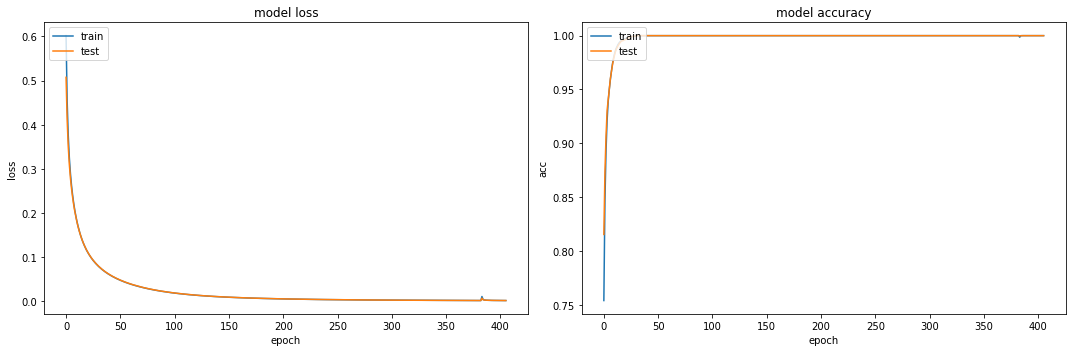

In [8]:
# summarize history for loss and acc
show_acc_loss_curves(dyn_history)

In [9]:
results = test_model(dyn_model, test_data, test="next")
print("loss: {}, acc: {}".format(results[0],results[1]))

loss: 0.0019886951726894924, acc: 1.0


### II.II. Transfer Learning
In order to better learn the probability that a given action in a specific situation leads to winning the game, we use the trained model from the previous task and attach 2 more layers on top of it. This is meant to use the knowledge gained about game dynamics for predicting the probability of winning after a given action.  

#### Distribution of labels
First however, we take a look at the distribution of outcome probabilities.  
As we can see, they are not equally distributed, which makes sense as most actions have a low probability of success. Two other peaks occur for ambigous actions (p~0.5) and actions with a high probability of winning.

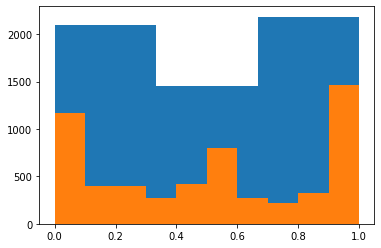

In [10]:
plt.hist(train_data["pred"],bins=3)
plt.hist(train_data["pred"])
plt.show()

In [11]:
# define cross entropy
def cross_entropy(y_true, y_pred):
    return tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred)

"""
creates deep copy of a model including its weights
"""
def copy_model(model, optimiser, set_weights):
    model_copy= clone_model(model)
    
    if optimiser == "nag":
        opt = SGD(learning_rate=learning_rate, nesterov=True)
    elif optimiser == "adam":
        opt = Adam(learning_rate=learning_rate)
        
    model_copy.compile(loss=cross_entropy, optimizer=opt, metrics=["acc"])
    if set_weights:
        model_copy.set_weights(model.get_weights())
    return model_copy

"""
creates model based on given input parameters
"""
def create_model(optimiser, learning_rate, c, transfer_learning, deepen_model, base_model):
    # transfer learning condition
    model = copy_model(base_model, optimiser, transfer_learning)
    model.pop()
    if deepen_model:
        if transfer_learning:
            model.layers[0].trainable = False
            start = Dense(120, activation='relu', activity_regularizer=l2(c))(model.layers[-1].output)
            end = Dense(250, activation='relu', activity_regularizer=l2(c))(start)
            out_r = Dense(1, activation="sigmoid", activity_regularizer=l2(c), name='r_prop')(end)
            final_model = Model(model.input,out_r)
        else:
            final_model = Sequential()
            final_model.add(Dense(120,input_dim=51, activation="relu", activity_regularizer=l2(c)))
            final_model.add(Dense(250, activation='relu', activity_regularizer=l2(c)))
            final_model.add(Dense(1, activation="sigmoid", activity_regularizer=l2(c), name='r_prop'))
    else:
        out_r = Dense(1, activation="sigmoid", activity_regularizer=l2(c),
                      name='r_prop')(model.layers[-1].output)
        final_model = Model(model.input,out_r)
        
    # Compile model
    if optimiser == "nag":
        opt = SGD(learning_rate=learning_rate, nesterov=True)
    elif optimiser == "adam":
        opt = Adam(learning_rate=learning_rate)
    final_model.compile(loss=cross_entropy, optimizer=opt, metrics=["acc"])
    
    return final_model

def run_3_fold_gridsearch(combinations, filename, model):
    # create containers for resulting data
    res_df = pd.DataFrame(columns=['transfer','deepened','optimiser','learning rate','batch size',
                                   'loss1', 'acc1','loss2', 'acc2','loss3', 'acc3'])
    hist_dict_global = {}


    # 3-fold grid search over the combinations defined above
    for i, combination in enumerate(combinations):

        kf = KFold(n_splits=3, random_state=42, shuffle=False)
        metrics_dict = {}

        print("{}/{}: {} - folds completed: ".format(i+1,len(combinations), combination), end="", flush=True)

        for j, (train_index, test_index) in enumerate(kf.split(train_data["input"])):
            X_train, X_test = train_data["input"][train_index], train_data["input"][test_index]
            y_train, y_test = train_data["pred"][train_index], train_data["pred"][test_index]

            # try to create and fit the model
            try:
                model = create_model(optimiser = combination[0], learning_rate = combination[1], 
                                     c = combination[3], transfer_learning = combination[5], 
                                     deepen_model = combination[6], base_model = model)
                es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=80, min_delta=0.001)
                hist = model.fit(X_train, y_train, epochs=combination[4], batch_size=combination[2],
                                 verbose=0, validation_data=(X_test, y_test), 
                                 use_multiprocessing = True, callbacks=[es])
            except Exception as error:
                print("\nTraining failed for {} - fold {}".format(combination, j+1))
                traceback.print_exc()

            # try to evaluate the model
            try:        
                loss, acc = test_model(model, test_data, test="pred")
                metrics_dict[j+1] = {"loss": loss, "acc": acc, "epoch_stopped": es.stopped_epoch}            
                if j < 2:
                    print("{}-".format(j+1), end="", flush=True)
                else:
                    print("{}".format(j+1))

            except Exception as error:
                metrics_dict[j+1] = {"loss": None}
                print("Metric calculations failed for {} - fold {}".format(combination, j+1))
                traceback.print_exc()

        row = {'transfer': combination[5], 'deepened': combination[6], 'optimiser': combination[0], 
               'learning rate': combination[1], 'batch size': combination[2], 'reg_penalty': combination[3],
               'epoch_stopped1': metrics_dict[1]["epoch_stopped"], 'loss1': metrics_dict[1]["loss"], 
               'acc1': metrics_dict[1]["acc"],
               'epoch_stopped2': metrics_dict[2]["epoch_stopped"], 'loss2': metrics_dict[2]["loss"], 
               'acc2': metrics_dict[2]["acc"],
               'epoch_stopped3': metrics_dict[3]["epoch_stopped"], 'loss3': metrics_dict[3]["loss"], 
               'acc3': metrics_dict[3]["acc"]}
        res_df = res_df.append(row , ignore_index=True)
        res_df.to_csv(filename, sep=";")

### II.III. Primary Analysis - Choice of optimiser
#### II.III.I Grid Search
To test which combination of optimiser, learning rate and batch size was best suited to the purpose of learning outcome probabilities using binary cross entropy, we created a grid search over the following parameters:  
- ***optimiser***: Nesterov Momentum (NAG), Adaptive Moment Estimation (ADAM)
- ***learning rate***: 0.0001, 0.001, 0.01
- ***batch size***: 10, 50, 100, 500  
  
Additionally, to test the effect of transfer learning and deepening the network we also searched over the options:
- ***transfer learning***: fixing the only layer after the first training (or 
- ***deepened***: adding an additonal two layers (```120-250```) 

In [ ]:
# set hyperparameter search space
optimiser = ["nag","adam"]
learning_rate = [0.0001, 0.001, 0.01]
batch_size = [10, 500, 100, 500]
reg_penalty = [0.01, 0.001, 0.0001]
max_epochs = [5000]
transfer = [True, False]
add_layers = [True, False]

# create list of all different parameter combinations
param_grid = dict(optimiser = optimiser, learning_rate = learning_rate, batch_size = batch_size, 
                  reg_penalty = reg_penalty, epochs = max_epochs, transfer = transfer, add_layers = add_layers)
combinations = list(product(*param_grid.values()))

run_3_fold_gridsearch(combinations, "nag_adam_comparison.csv", dyn_model)

### Analysis
The first grid search consisted of 128 different combinations with 3 results for loss and accuracy.

In [12]:
col_list = ['optimiser', 'transfer', 'deepened', 'learning rate', 'batch size', 'loss_mean', 'loss_std',
            'loss_min', 'acc_mean', 'acc_std', 'epochs_mean', 'epochs_std']

In [13]:
data_raw = pd.read_csv("nag_adam_comparison.csv", sep=";", index_col=0)
data_raw.shape

(128, 14)

#### II.III.II. NaN-Examination
Unfortunately, due to unlucky combinations of optimiser, batch size and learning rate some of the results are represented as ```NaN``` values.

In [14]:
null_columns=data_raw.columns[data_raw.isnull().any()]
idx = data_raw.index[data_raw.isnull().any(1)]
print("Out of {} results, {} contain NaNs.".format(data_raw.shape[0], data_raw.loc[idx,:].shape[0]))
print("The columns including NaNs are {}".format(list(null_columns)))
# check for nan values in mae columns
data_raw["loss_na"] = data_raw.loc[:,["loss1","loss2", "losse3"]].isnull().sum(1)

Out of 128 results, 104 contain NaNs.
The columns including NaNs are ['loss1', 'loss2', 'loss3']


/home/lks/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


At first, we check if the creation of NaNs had anything to do with teh usage of transfer learning or deeening the model.  
But as it turns out, the distribution is the same for all conditions. We can clearly see however, that most NaNs not usable for analysis (2 or more NaNs) are produced by using the ADAM optimiser.

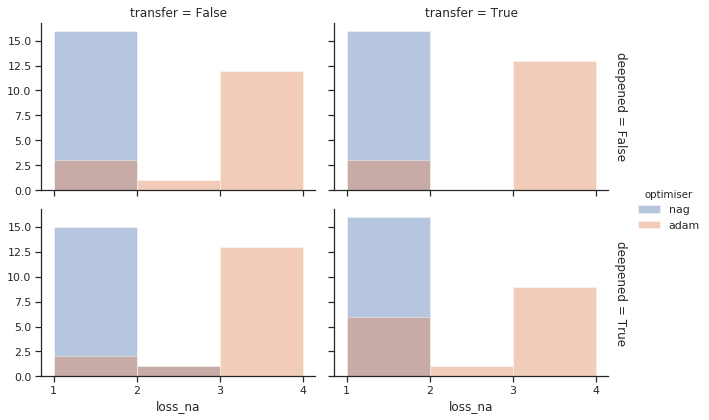

In [32]:
g = sns.FacetGrid(data_raw, hue ="optimiser", col="transfer", row = "deepened", sharey=True, aspect=1.5, margin_titles=True)
bins = [1,2,3,4] #
g.map(sns.distplot,"loss_na", kde = False, bins = bins, hist=True)
g.add_legend()
plt.xticks(bins)
plt.show()

As a second step, we take a look at how batch size and learning rate influence the creation of NaNs.  
We see again, that NAG only produces single NaN occurences while ADAM oftentimes leads to two or more NaN losses within the same combination.
The number of NaNs created is similar for over the various batch sizes. Notably ADAM seems to create the least NaNs with a high batch size and a small learning rate.

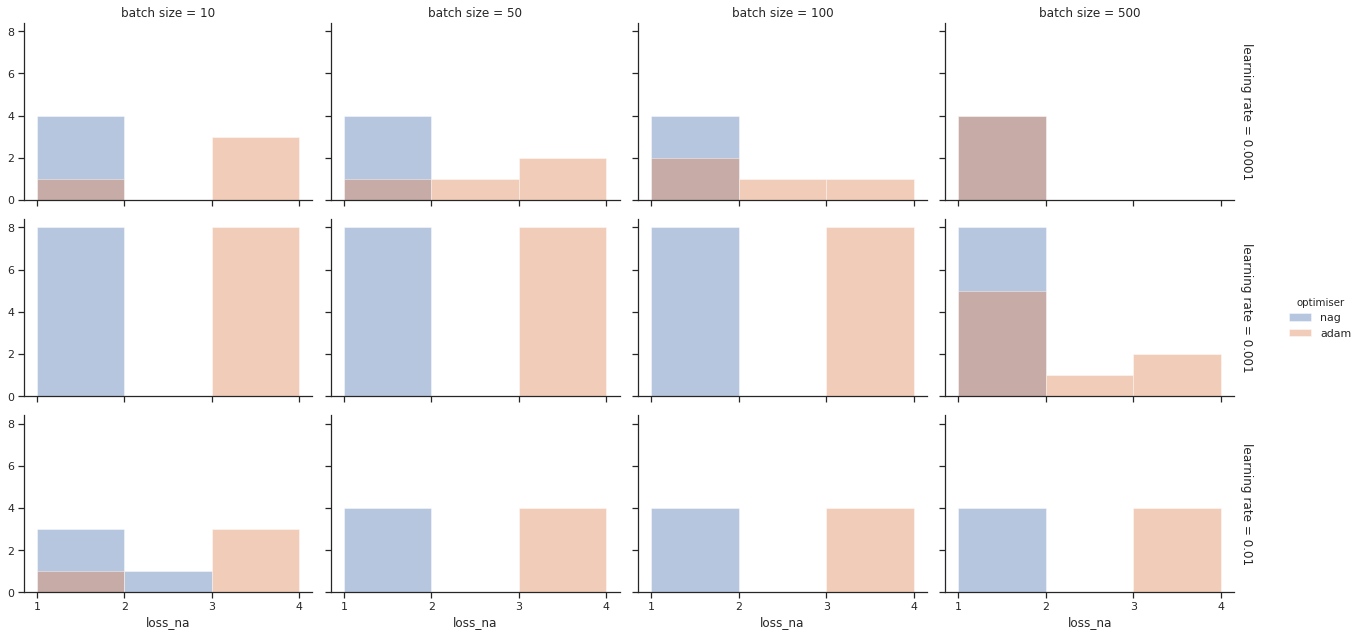

In [33]:
g = sns.FacetGrid(data_raw, col="batch size", row = "learning rate", hue ="optimiser", sharey=True, aspect=1.5, margin_titles=True)
bins = [1,2,3,4] #
g.map(sns.distplot,"loss_na", kde = False, bins = bins, hist=True)
g.add_legend()
plt.xticks(bins)
plt.show()

In [20]:
# remove rows that don't have a at least 2 mae scores
data_rm_na = data_raw[(data_raw.loss_na < 2)]
data = data_rm_na.copy()
print("Removing all runs with 2 or more missing losses. That leaves {} runs for adam and {} runs for nag.".format(data.loc[data['optimiser'] == "adam"].shape[0], data.loc[data['optimiser'] == "nag"].shape[0]))

Removing all runs with 2 or more missing losses. That leaves 14 runs for adam and 63 runs for nag.


In [21]:
# compute aggregation metrics
data["loss_mean"] = data[['loss1', 'loss2', 'loss3']].mean(axis=1, skipna = True)
data["loss_std"] = data[['loss1', 'loss2', 'loss3']].std(axis=1, skipna = True)
data["acc_mean"] = data[['acc1', 'acc2', 'acc3']].mean(axis=1, skipna = True)
data["acc_std"] = data[['acc1', 'acc2', 'acc3']].std(axis=1, skipna = True)
data["epochs_mean"] = data[['epoch_stopped1', 'epoch_stopped2', 'epoch_stopped3']].mean(axis=1, skipna = True)
data["epochs_std"] = data[['epoch_stopped1', 'epoch_stopped2', 'epoch_stopped3']].std(axis=1, skipna = True)
# get minimum value
data["loss_min"] = data[["loss1","loss2", "loss3"]].min(1)

#### II.III.II. Calculation and analysis of aggregation metrics (loss mean and std)
To get a better overview of the different performance for the different combinations, we want to group the data by last activation, loss function and optimiser and average over all learning rates and batch sizes.  
However, to see if this is justified, we first have to take a look a the mean loss for batch sizes and learning rates in order to check if the mean accurately approximates the mae over all conditions.

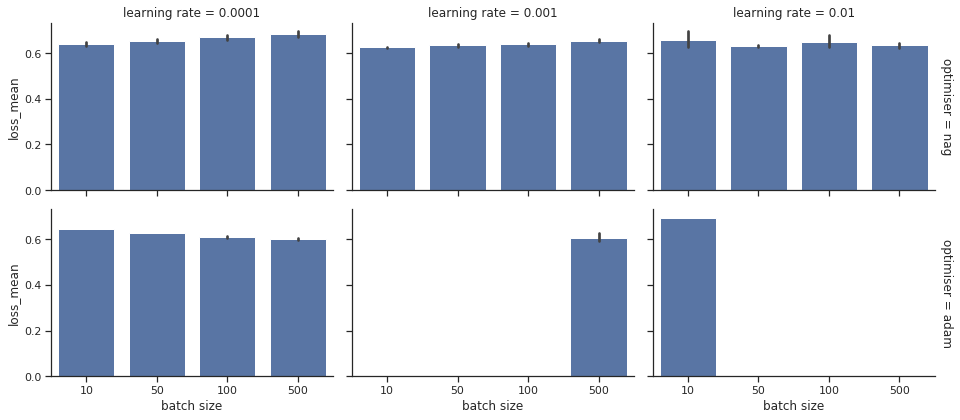

In [23]:
g = sns.FacetGrid(data, col="learning rate", row = "optimiser", sharey=True, aspect=1.5, margin_titles=True)
g.map(sns.barplot, "batch size", "loss_mean", order = [10, 50, 100, 500])
plt.show()

The next step is to remove all instances with 2 or more missing maes as otherwise no meaningful aggreagation metrics can be computed.
Afterwards we calculate mean and standard devaiation of the mea estimate and save the minimum value from all 3 folds also,
This greatly reduces the available number of observations for ADAM.

When looking at the Top20 results sorted by the mean loss over all folds, we can see that, even though we only have few observations for the ADAM optimiser it achieves the lowest losses. It generally seems to work best with big batch sizes and small learning rates while the results for NAG are more varied but achieve the best results with a little more aggressive learning rates.  
The standard deviations are small across the board as well.
The generall size of the log loss around 0.6 is not very satisfying at all though.  
Also the difference between the two optimisers is rather small with a difference of 0.0239 between the best perfoming combinations for both both optimisers.

In [24]:
data.sort_values(axis=0, by="loss_mean")[col_list].head(20)

,optimiser,transfer,deepened,learning rate,batch size,loss_mean,loss_std,loss_min,acc_mean,acc_std,epochs_mean,epochs_std
15,adam,False,False,0.0001,500,0.592863,0.006222,0.585704,0.150706,0.001570,885.666667,179.187983
47,adam,False,False,0.0010,500,0.593203,0.006611,0.585696,0.148090,0.004796,190.000000,28.513155
29,adam,True,False,0.0010,500,0.594753,0.003298,0.591379,0.145474,0.003951,519.666667,81.002058
45,adam,True,False,0.0010,500,0.596319,0.004903,0.592721,0.145997,0.001570,582.000000,104.014422
31,adam,False,False,0.0010,500,0.598233,0.006597,0.590643,0.148613,0.002398,190.000000,51.507281
14,adam,False,True,0.0001,500,0.600342,0.005557,0.594035,0.148090,0.003268,232.000000,36.428011
13,adam,True,False,0.0001,500,0.607310,0.001851,0.605993,0.147043,0.003268,2196.000000,323.853362
10,adam,False,True,0.0001,100,0.607452,0.009745,0.599347,0.145474,0.004532,153.333333,24.704925
12,adam,True,True,0.0001,500,0.608760,0.010991,0.596376,0.147567,0.001570,258.666667,33.605555
8,adam,True,True,0.0001,100,0.612731,0.006482,0.605936,0.145997,0.002719,157.333333,19.655364


#### II.III.III Analysing the effect of transfer learning and network deepening
To see if transfer learning an model deepening had an effect on model performance, we plot the average loss over the four conditions.  
As we can see, the conditions, much as the previous results are almost identical with a slight advantage for adam and models that did not make use of transfer learning. If transfer learning is used however, interestingly, the models without extra layers perform slightly better.  
Considering the marignal differences in loss however, it seems fair to say that all conditions perform equally bad.

/home/lks/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


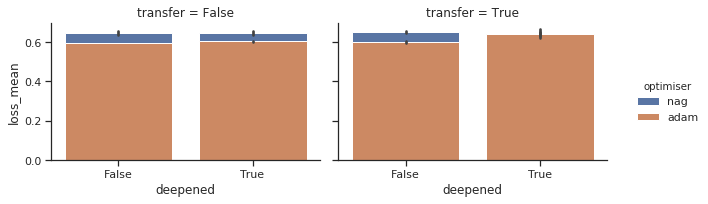

In [25]:
g = sns.FacetGrid(data, hue="optimiser",col="transfer", sharey=True, aspect=1.5, margin_titles=True)
g.map(sns.barplot, "deepened", "loss_mean").add_legend()
plt.show()

When looking at the epochs it takes for the model to find a stable configuration, we see that only NAG seems to profit from transfer learning - with no difference in deepening the model. For ADAM the opposite is true - it takes longer to achieve a stable state when transfer learning is enabled and only profits if the model has previously been deepened.

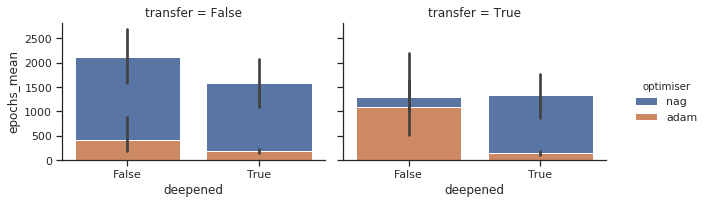

In [26]:
g = sns.FacetGrid(data, hue= "optimiser",col="transfer", sharey=True, aspect=1.5, margin_titles=True)
g.map(sns.barplot, "deepened", "epochs_mean").add_legend()
plt.show()

Due to the superior speed in all conditions however, we chose too limit our further analyses to the ADAM optimiser.

### II.IV. Secondary Analysis - Results with Regularisation
#### II.IV.I Regularised Model
After completing the first analysis and having chosen a optimiser, we identified two more areas of improvement:
- numerical stability to avoid creating NaNs
- adding regularisarion to the previously unregularised model  

So the orignal model was re-run using Dropout in the last layer and L2 regularisation:

In [27]:
reg_model = Sequential()
reg_model.add(Dense(120,input_dim=51, activation="relu", activity_regularizer=l2(0.01)))
reg_model.add(Dropout(0.25))
reg_model.add(Dense(30, activation='sigmoid', activity_regularizer=l2(0.01)))
reg_model.compile(loss='binary_crossentropy',
              optimizer='adam', # Root Mean Square Propagation
              metrics=['acc']) # Accuracy performance metric
reg_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 120)               6240      
_________________________________________________________________
dropout (Dropout)            (None, 120)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 30)                3630      
Total params: 9,870
Trainable params: 9,870
Non-trainable params: 0
_________________________________________________________________


In [28]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=50, min_delta=0.0005)
reg_history = reg_model.fit(train_data["input"], train_data["next"], epochs=500, batch_size=50, verbose=0, 
                        validation_split=0.1, callbacks=[es])

#### Results  
The results show that the regularised network also overfit to the training data. Indeed, it fits so perfectly that the testing loss ends up (not as high as the unregularised network but still) below the training loss and the testing accuracy surpasses the training accuracy just after a few epochs.  
Again, as generalisation is not needed in this task of representing "general dynamics", this kind of overfitting can be tolerated.

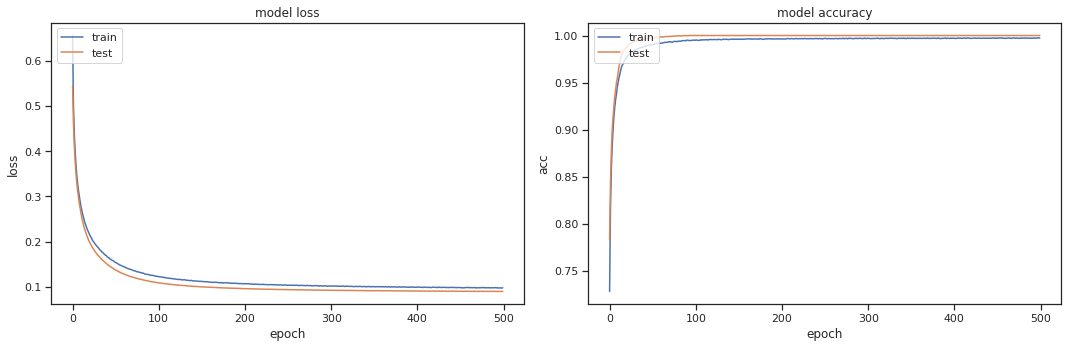

In [29]:
# summarize history for loss and acc
show_acc_loss_curves(reg_history)

In [30]:
results = test_model(reg_model, test_data, test="next")
print("loss: {}, acc: {}".format(results[0],results[1]))

loss: 0.0897911029576881, acc: 1.0


#### II.IV.II Grid Search
We now test again with an improved loss and final activation (using softmax cross entropy with logits by tensorflow for numerical stability) using only ADAM optimisation for the best combination of learning rate, batch size  and regularisation term.  
- ***learning rate***: 0.0001, 0.001, 0.01
- ***batch size***: 10, 50, 100, 500  
- ***regularisation term c***: 0.01, 0.001, 0.0001
  
We again evaluate the effect of transfer learning and deepening the network searching over the options:
- ***transfer learning***: fixing the only layer after the first training (or 
- ***deepened***: adding an additonal two layers (```120-250```) 

In [ ]:
# set hyperparameter search space
optimiser = ["nag","adam"]
learning_rate = [0.0001, 0.001, 0.01, 0.1]
batch_size = [10, 500, 100, 500]
reg_penalty = [0.01, 0.001, 0.0001]
max_epochs = [5000]
transfer = [True, False]
add_layers = [True, False]

# create list of all different parameter combinations
param_grid = dict(optimiser = optimiser, learning_rate = learning_rate, batch_size = batch_size, 
                  reg_penalty = reg_penalty, epochs = max_epochs, transfer = transfer, add_layers = add_layers)
combinations = list(product(*param_grid.values()))

run_3_fold_gridsearch(combinations, "grid_search_reg.csv", reg_model)

### Analysis
The first grid search consisted of 192 different combinations with 3 results for loss and accuracy.

In [34]:
col_list = ['optimiser', 'transfer', 'deepened', 'learning rate', 'batch size', 'reg_penalty', 'loss_mean', 'loss_std',
            'loss_min', 'acc_mean', 'acc_std', 'epochs_mean', 'epochs_std']

In [35]:
data_raw = pd.read_csv("grid_search_reg.csv", sep=";", index_col=0)
data_raw.shape

(192, 15)

#### II.IV.III. NaN-Examination
Using the improved loss function proved successfull as no NaNs were created during the training.

In [36]:
null_columns=data_raw.columns[data_raw.isnull().any()]
idx = data_raw.index[data_raw.isnull().any(1)]
print("Out of {} results, {} contain NaNs.".format(data_raw.shape[0], data_raw.loc[idx,:].shape[0]))
print("The columns including NaNs are {}".format(list(null_columns)))
# check for nan values in mae columns
data_raw["loss_na"] = data_raw.loc[:,["loss1","loss2", "losse3"]].isnull().sum(1)
data = data_raw.copy()

Out of 192 results, 0 contain NaNs.
The columns including NaNs are []


#### II.IV.IV. Calculation and analysis of aggregation metrics (loss mean and std)
To get a better overview of the different performance for the different combinations, we want to group the data by last activation, loss function and optimiser and average over all learning rates and batch sizes.  
However, to see if this is justified, we first have to take a look a the mean loss for batch sizes and learning rates in order to check if the mean accurately approximates the mae over all conditions.

In [37]:
# compute aggregation metrics
data["loss_mean"] = data[['loss1', 'loss2', 'loss3']].mean(axis=1, skipna = True)
data["loss_std"] = data[['loss1', 'loss2', 'loss3']].std(axis=1, skipna = True)
data["acc_mean"] = data[['acc1', 'acc2', 'acc3']].mean(axis=1, skipna = True)
data["acc_std"] = data[['acc1', 'acc2', 'acc3']].std(axis=1, skipna = True)
data["epochs_mean"] = data[['epoch_stopped1', 'epoch_stopped2', 'epoch_stopped3']].mean(axis=1, skipna = True)
data["epochs_std"] = data[['epoch_stopped1', 'epoch_stopped2', 'epoch_stopped3']].std(axis=1, skipna = True)
# get minimum value
data["loss_min"] = data[["loss1","loss2", "loss3"]].min(1)

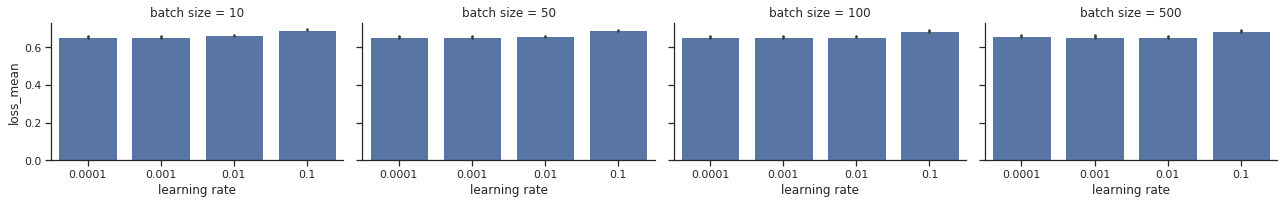

In [38]:
g = sns.FacetGrid(data, col = "batch size", sharey=True, aspect=1.5, margin_titles=True)
g.map(sns.barplot, "learning rate", "loss_mean", order = [0.0001, 0.001, 0.01, 0.1])
plt.show()

When looking at the Top20 results sorted by the mean loss over all folds, we can see that due to regularisation the average loss has increased by about 0.5. Also the penalty term does not seem to greatly affect the loss (with an advantage for small regularisation terms).

In [39]:
data.sort_values(axis=0, by="loss_mean")[col_list].head(20)

,optimiser,transfer,deepened,learning rate,batch size,reg_penalty,loss_mean,loss_std,loss_min,acc_mean,acc_std,epochs_mean,epochs_std
125,adam,True,False,0.0010,100,0.0010,0.643949,0.004509,0.639903,0.128205,0.003268,259.000000,23.643181
149,adam,True,False,0.0001,10,0.0010,0.644050,0.002747,0.641841,0.125065,0.001813,396.000000,53.018865
127,adam,False,False,0.0010,100,0.0010,0.644056,0.001912,0.642760,0.127159,0.004153,265.333333,27.754879
131,adam,False,False,0.0010,100,0.0001,0.644785,0.002324,0.642497,0.126112,0.002398,283.666667,6.027714
117,adam,True,False,0.0010,50,0.0001,0.644943,0.002305,0.642298,0.125065,0.003268,196.333333,51.791248
151,adam,False,False,0.0001,10,0.0010,0.645017,0.001530,0.643344,0.121402,0.000906,417.333333,79.147542
113,adam,True,False,0.0010,50,0.0010,0.645028,0.002804,0.642872,0.126112,0.001813,271.000000,109.421205
153,adam,True,False,0.0001,10,0.0001,0.645097,0.001429,0.643477,0.126112,0.003268,347.666667,39.463063
141,adam,True,False,0.0010,500,0.0001,0.645304,0.001717,0.643759,0.125065,0.000906,435.333333,22.678918
105,adam,True,False,0.0010,10,0.0001,0.645331,0.004321,0.642092,0.126635,0.005046,166.333333,35.725808


#### II.IV.V Analysing the effect of transfer learning and network deepening
This time transfer leaning does not seem to make a difference in performance either.

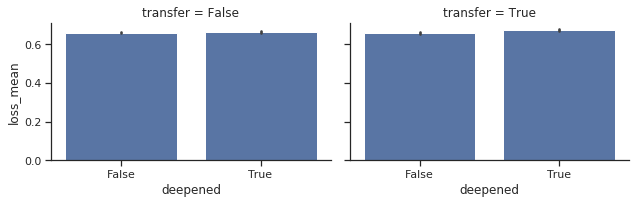

In [40]:
g = sns.FacetGrid(data, col="transfer", sharey=True, aspect=1.5, margin_titles=True)
g.map(sns.barplot, "deepened", "loss_mean")
plt.show()

When looking at the epochs it takes for the model to find a stable configuration, we can replicate the results from the optimiser comparison: For models which are not deepened, transfer learning seems to have a small (and not significant) effect. Instead the real effect for increasing the speed of a stable solution seems to lie in deepening the network.

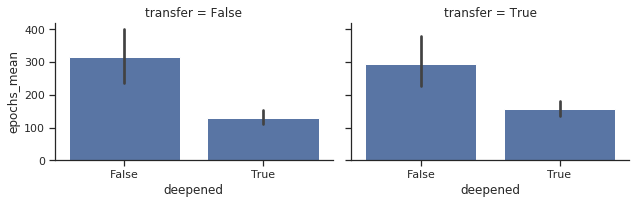

In [41]:
g = sns.FacetGrid(data, col="transfer", sharey=True, aspect=1.5, margin_titles=True)
g.map(sns.barplot, "deepened", "epochs_mean")
plt.show()

### III. Outlook

From these experiments, two conclusions can be drawn if a good and time-efficient prediction of outcome probabilities should be achieved:
    - more data is needed for training
    - the network should be deepened